In [1]:
! pip install optuna

In [2]:
import numpy as np
import pandas as pd
import os

import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from catboost import Pool, CatBoostClassifier, cv, CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error
import optuna
from scipy.stats import skew, norm, shapiro

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
train = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/train.csv')
test = pd.read_csv('/kaggle/input/house-prices-advanced-regression-techniques/test.csv')

datasets=[train, test]

In [4]:
#this function give you all useful info about column
def info_col(column):  
  nulls=train[column].isnull().sum(axis=0)
  print('Train:', nulls[nulls>0])
  nulls=test[column].isnull().sum(axis=0)
  print('Test:', nulls[nulls>0])
  type_col=train[column].dtype
  print('Type: ', type_col)
  print('In test and not in train:', list(set(test[column])-set(train[column])))
  print(train[column].value_counts())

In [5]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,8,2007,WD,Normal,175000
1456,1457,20,RL,85.0,13175,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,MnPrv,NaN,0,2,2010,WD,Normal,210000
1457,1458,70,RL,66.0,9042,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,GdPrv,Shed,2500,5,2010,WD,Normal,266500
1458,1459,20,RL,68.0,9717,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,4,2010,WD,Normal,142125


/tmp/ipykernel_20/823661084.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train['SalePrice'], kde=True, hist=True)


<Axes: xlabel='SalePrice', ylabel='Density'>

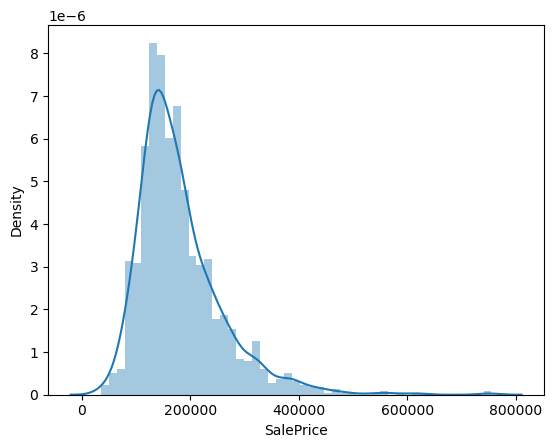

In [6]:
sns.distplot(train['SalePrice'], kde=True, hist=True)

/tmp/ipykernel_20/1794600353.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  mat = train.corr('spearman')


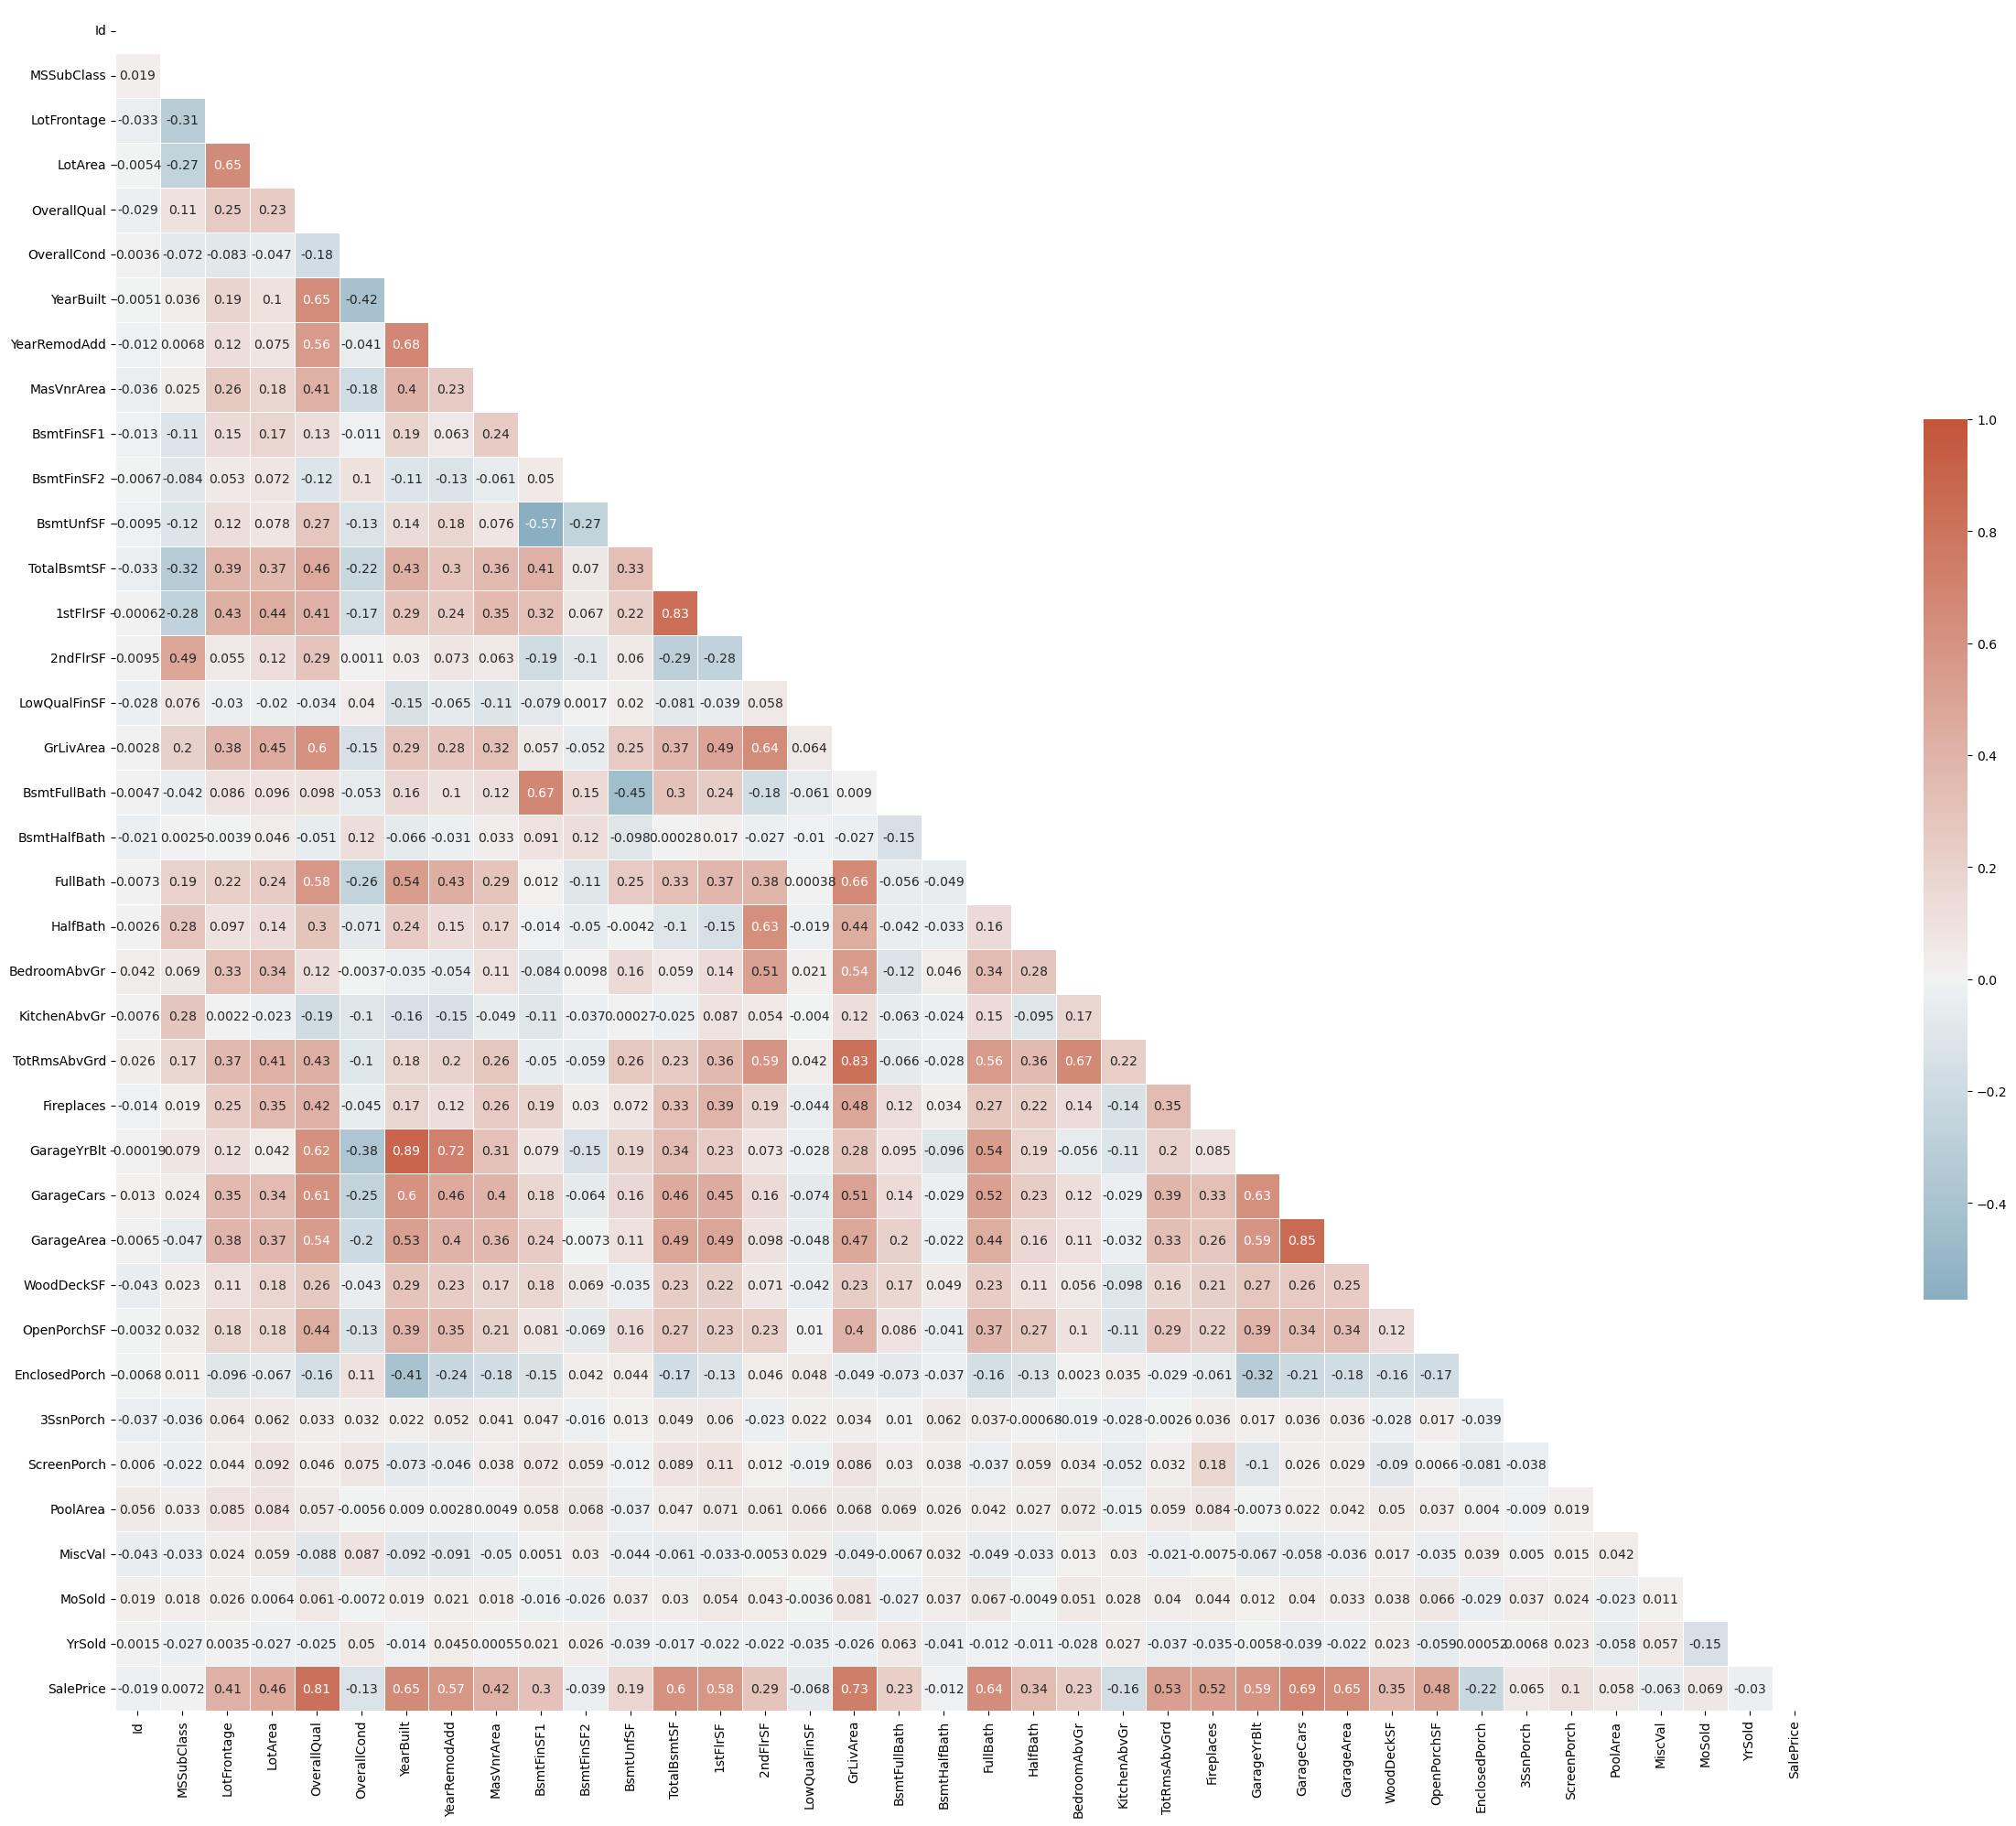

In [7]:
f, ax = plt.subplots(figsize=(30, 25))
mat = train.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0, annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [8]:
int_columns = train.select_dtypes(include=['int64']).columns.tolist()
float_columns = train.select_dtypes(include=['float64']).columns.tolist()
object_columns = train.select_dtypes(include=['object']).columns.tolist()

print("Столбцы типа int64:", int_columns)
print("Столбцы типа float64:", float_columns)
print("Столбцы типа object:", object_columns)

Столбцы типа int64: ['Id', 'MSSubClass', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
Столбцы типа float64: ['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
Столбцы типа object: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 

In [9]:
threshold = 0.2
missing_percentages = train.isnull().mean()
columns_to_drop = missing_percentages[missing_percentages > threshold].index
#['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']
for df in datasets:
  df.drop(columns_to_drop, axis=1, inplace=True)
  #ints
  columns_to_zero=['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'GarageArea']
  df['MSSubClass']=df['MSSubClass'].astype(str)
  df['MSSubClass']=df['MSSubClass'].apply(lambda x: '120' if x=='150' else x)
  for i in columns_to_zero:
    df[i].fillna(0, inplace=True)
  #floats
  columns_to_mode_f=['LotFrontage', 'MasVnrArea']
  for i in columns_to_mode_f:
     df[i].fillna(df[i].mode().loc[0], inplace=True)
  df['GarageYrBlt'].fillna(0, inplace=True)
  df['GarageYrBlt']=df['GarageYrBlt'].astype(int)
  #objects
  columns_to_mode_o=['MSZoning', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
                     'KitchenQual', 'Electrical', 'Functional', 'SaleType']
  columns_rate=['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
             'HeatingQC', 'KitchenQual', 'GarageQual', 'GarageCond']
  columns_no_type=['GarageType', 'GarageFinish']
  for i in columns_to_mode_o:
    df[i].fillna(df[i].mode().loc[0], inplace=True)
  for i in columns_rate:
    df[i].fillna(0, inplace=True)
  for i in columns_rate:
    df[i] = df[i].replace({'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1,
                                         'Av': 3, 'Mn': 2, 'No': 0,
                                         'GLQ': 5, 'ALQ': 4, 'BLQ': 3, 'Rec': 2, 'LwQ': 1, 'Unf': 0})
  for i in columns_no_type:
    df[i].fillna('No_type', inplace=True)
  #feature_engineering
  df['Age']=df['YrSold']-df['YearBuilt']
  df['TotalQuality']=df['OverallQual']+df['OverallCond']
  df['GarageQuality']=df['GarageQual']+df['GarageCond']
  df['TotalFloor']=df['TotalBsmtSF']+df['1stFlrSF']+df['2ndFlrSF']
  df['TotalPorch']=(df['OpenPorchSF']+df['3SsnPorch']+df['EnclosedPorch']+df['ScreenPorch']+df['WoodDeckSF'])

  df['Renovate'] = pd.to_numeric(df['YearRemodAdd']) - pd.to_numeric(df['YearBuilt'])
  df['HighQualS'] = df['GrLivArea']+df['1stFlrSF']+df['2ndFlrSF']+0.5*df['GarageArea']+0.5 * df['TotalBsmtSF'] + 1 * df['MasVnrArea']
  df['Total_Bathrooms'] = (df['FullBath'] + (0.5 * df['HalfBath']) +df['BsmtFullBath'] + (0.5*df['BsmtHalfBath']))

  list_to_log=['TotalFloor', 'TotalBsmtSF', 'GarageCars', 'LotFrontage']
  for i in list_to_log:
    name=f'{i}_log'
    df[name]=np.log1p(df[i])






In [10]:
train

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,GarageQuality,TotalFloor,TotalPorch,Renovate,HighQualS,Total_Bathrooms,TotalFloor_log,TotalBsmtSF_log,GarageCars_log,LotFrontage_log
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,6,2566,61,0,4318.0,3.5,7.850493,6.753438,1.098612,4.189655
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,6,2524,298,0,3385.0,2.5,7.833996,7.141245,1.098612,4.394449
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,6,2706,42,1,4498.0,3.5,7.903596,6.825460,1.098612,4.234107
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,6,2473,307,55,4133.0,2.0,7.813592,6.629363,1.386294,4.110874
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,6,3343,276,0,5736.5,3.5,8.114923,7.044033,1.386294,4.442651
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,60,RL,62.0,7917,Pave,Reg,Lvl,AllPub,Inside,...,6,2600,40,1,4000.5,2.5,7.863651,6.860664,1.098612,4.143135
1456,1457,20,RL,85.0,13175,Pave,Reg,Lvl,AllPub,Inside,...,6,3615,349,10,5286.0,3.0,8.193124,7.341484,1.098612,4.454347
1457,1458,70,RL,66.0,9042,Pave,Reg,Lvl,AllPub,Inside,...,6,3492,60,65,5382.0,2.0,8.158516,7.050123,0.693147,4.204693
1458,1459,20,RL,68.0,9717,Pave,Reg,Lvl,AllPub,Inside,...,6,2156,478,46,2815.0,2.0,7.676474,6.983790,0.693147,4.234107


In [11]:
info_col('BsmtHalfBath')

Train: []
Test: []
Type:  int64
In test and not in train: []
0    1378
1      80
2       2
Name: BsmtHalfBath, dtype: int64


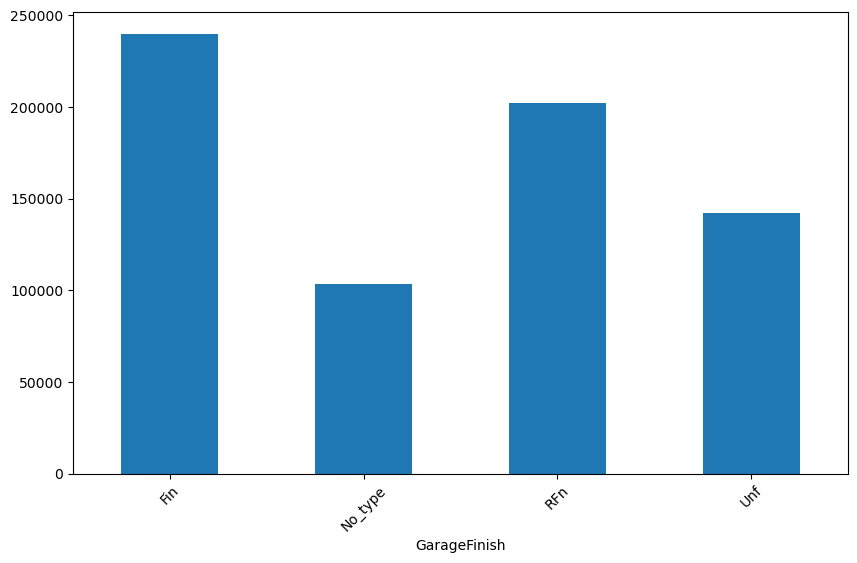

In [12]:
avg_prices = train.groupby('GarageFinish')['SalePrice'].mean()

# Создайте график
plt.figure(figsize=(10, 6))
avg_prices.plot(kind='bar')
plt.xticks(rotation=45)
plt.show()

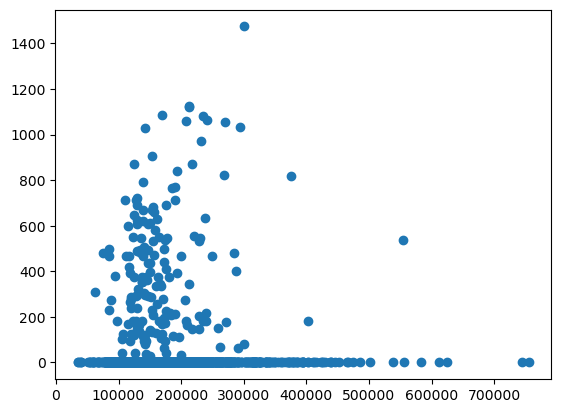

In [13]:
plt.scatter(train['SalePrice'], train['BsmtFinSF2'])

In [14]:
nulls=train.isnull().sum(axis=0)
print('Train:', nulls[nulls>0])
nulls=test.isnull().sum(axis=0)
print('Test:', nulls[nulls>0])

Train: Series([], dtype: int64)
Test: Series([], dtype: int64)


In [15]:
categorical_features_indices=['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
                              'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
                              'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'Foundation',
                              'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageType', 'GarageFinish',
                              'PavedDrive', 'SaleType', 'SaleCondition']

In [16]:
def objective(trial):
    X=train.drop('SalePrice', axis=1)
    y=train['SalePrice']
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
    X_test=test

    param = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
        'l2_leaf_reg': trial.suggest_int("l2_leaf_reg", 1, 3)
    }
    model = CatBoostRegressor(**param)

    model.fit(X_train, y_train,eval_set=[(X_validation, y_validation)], cat_features=categorical_features_indices,
              early_stopping_rounds=200,verbose=0)

    preds = model.predict(X_validation)

    rmse = mean_squared_error(y_validation, preds,squared=False)

    return rmse

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, timeout=360)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-08-17 18:29:01,721] A new study created in memory with name: no-name-f4b1c2bf-43a3-4017-8fbe-ba0f1eb2a0ff
[I 2023-08-17 18:29:04,065] Trial 0 finished with value: 26230.330479153123 and parameters: {'learning_rate': 0.021452243253367753, 'depth': 2, 'subsample': 0.5289844359551334, 'colsample_bylevel': 0.6407352327980632, 'min_data_in_leaf': 75, 'l2_leaf_reg': 1}. Best is trial 0 with value: 26230.330479153123.
[I 2023-08-17 18:29:55,546] Trial 1 finished with value: 50250.78504290004 and parameters: {'learning_rate': 0.0010231194059708456, 'depth': 9, 'subsample': 0.5747218660088032, 'colsample_bylevel': 0.49749500706772676, 'min_data_in_leaf': 30, 'l2_leaf_reg': 2}. Best is trial 0 with value: 26230.330479153123.
[I 2023-08-17 18:30:04,754] Trial 2 finished with value: 24809.885579110673 and parameters: {'learning_rate': 0.036924127269440714, 'depth': 6, 'subsample': 0.7141997394419711, 'colsample_bylevel': 0.40490611360349005, 'min_data_in_leaf': 24, 'l2_leaf_reg': 3}. Best 

Number of finished trials: 21
Best trial:
  Value: 23905.6245262854
  Params: 
    learning_rate: 0.030232719659191026
    depth: 4
    subsample: 0.7322846516815705
    colsample_bylevel: 0.8679376357365571
    min_data_in_leaf: 47
    l2_leaf_reg: 2


In [17]:
mse =[]
model_names =[]


X=train.drop('SalePrice', axis=1)
y=train['SalePrice']
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_test=test

model = CatBoostRegressor(verbose=False,random_state=42,
    learning_rate= 0.09830207943225598,
    depth= 6,
    subsample= 0.983963217735898,
    colsample_bylevel= 0.49010702589268,
    min_data_in_leaf= 5,
    l2_leaf_reg= 1
)

model.fit(X_train, y_train, cat_features=categorical_features_indices, eval_set=(X_validation, y_validation),
          early_stopping_rounds=200,verbose=0)
y_pred = model.predict(X_validation)
mse=(mean_squared_error(y_validation, y_pred))
print(mse)

model_names = ['Catboost_tuned']
result_df6 = pd.DataFrame({'RMSE':mse}, index=model_names)
result_df6

581813830.587589


,RMSE
Catboost_tuned,5.818138e+08


In [18]:
col_more_than_1, col_more_than_1_te = [], []

train_pool = Pool(X_train, y_train, cat_features=categorical_features_indices)

feature_importances = model.get_feature_importance(train_pool)
feature_names = X_train.columns
for score, name in sorted(zip(feature_importances, feature_names), reverse=True):
    print('{}: {}'.format(name, score))
    if score>=0.01:
      col_more_than_1.append(name)
      col_more_than_1_te.append(name)

col_more_than_1.append('SalePrice')

OverallQual: 17.079451538950423
TotalFloor: 13.915014233758457
TotalFloor_log: 7.23890218562967
GrLivArea: 4.965589908545233
HighQualS: 3.2348099049509496
KitchenQual: 2.811366268202052
LotArea: 2.7305263732752376
GarageCars_log: 2.497200873251191
Age: 2.3159643555721163
Fireplaces: 2.2080741831180215
TotalQuality: 2.2065618133118847
ExterQual: 1.969115523552912
GarageYrBlt: 1.9370050431725792
BsmtQual: 1.8527870839392124
LandContour: 1.8492792207962971
BsmtFinSF1: 1.7017668067774814
TotalBsmtSF: 1.6933335559263836
Total_Bathrooms: 1.4671516056234557
FullBath: 1.4454158234716863
BsmtExposure: 1.3441240648888289
SaleCondition: 1.245744871943697
BsmtFinType1: 1.2385492318569276
OverallCond: 1.13716961616814
Neighborhood: 1.1066424210480479
GarageFinish: 1.0908288569109188
1stFlrSF: 0.9686655864301942
YearRemodAdd: 0.9008944074470843
WoodDeckSF: 0.8536165132748479
LotFrontage: 0.7647570736531889
TotalBsmtSF_log: 0.7448720305940462
BsmtUnfSF: 0.7300202032282563
GarageArea: 0.70106095545223

In [19]:
train_more_than_1=train[col_more_than_1]
test_more_than_1=test[col_more_than_1_te]

In [20]:
train_more_than_1

,OverallQual,TotalFloor,TotalFloor_log,GrLivArea,HighQualS,KitchenQual,LotArea,GarageCars_log,Age,Fireplaces,...,HeatingQC,GarageCond,KitchenAbvGr,BsmtFinSF2,BsmtCond,ExterCond,3SsnPorch,GarageQuality,Foundation,SalePrice
0,7,2566,7.850493,1710,4318.0,4,8450,1.098612,5,0,...,5,3,1,0,3,3,0,6,PConc,208500
1,6,2524,7.833996,1262,3385.0,3,9600,1.098612,31,1,...,5,3,1,0,3,3,0,6,CBlock,181500
2,7,2706,7.903596,1786,4498.0,4,11250,1.098612,7,1,...,5,3,1,0,3,3,0,6,PConc,223500
3,7,2473,7.813592,1717,4133.0,4,9550,1.386294,91,1,...,4,3,1,0,4,3,0,6,BrkTil,140000
4,8,3343,8.114923,2198,5736.5,4,14260,1.386294,8,1,...,5,3,1,0,3,3,0,6,PConc,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,6,2600,7.863651,1647,4000.5,3,7917,1.098612,8,1,...,5,3,1,0,3,3,0,6,PConc,175000
1456,6,3615,8.193124,2073,5286.0,3,13175,1.098612,32,2,...,3,3,1,163,3,3,0,6,CBlock,210000
1457,7,3492,8.158516,2340,5382.0,4,9042,0.693147,69,2,...,5,3,1,0,4,4,0,6,Stone,266500
1458,5,2156,7.676474,1078,2815.0,4,9717,0.693147,60,0,...,4,3,1,1029,3,3,0,6,CBlock,142125


In [21]:
categorical_features_indices_more1=list(set(categorical_features_indices)&set(col_more_than_1))

In [22]:
categorical_features_indices_more1

['CentralAir',
 'Exterior1st',
 'MSSubClass',
 'RoofStyle',
 'Neighborhood',
 'LotConfig',
 'PavedDrive',
 'Condition1',
 'HouseStyle',
 'Foundation',
 'SaleType',
 'Exterior2nd',
 'Condition2',
 'LandContour',
 'LandSlope',
 'MasVnrType',
 'LotShape',
 'GarageFinish',
 'GarageType',
 'BldgType',
 'SaleCondition',
 'Electrical',
 'MSZoning',
 'Functional']

In [23]:
target = train_more_than_1['SalePrice']
target_log = np.log1p(target)

In [24]:
def objective(trial):
    X=train_more_than_1.drop('SalePrice', axis=1)
    y=target_log
    X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
    X_test=test_more_than_1

    param = {
        "iterations": 1000,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.05, 1.0),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
    }
    model_m1 = CatBoostRegressor(**param)

    model_m1.fit(X_train, y_train,eval_set=[(X_validation, y_validation)], cat_features=categorical_features_indices_more1,
              early_stopping_rounds=200,verbose=0)

    preds = model_m1.predict(X_validation)

    rmse = mean_squared_error(y_validation, preds, squared=False)

    return rmse

if __name__ == "__main__":
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=50, timeout=360)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2023-08-17 18:36:04,859] A new study created in memory with name: no-name-bca67b09-b0d7-4f14-a110-81f5cd847c05
[I 2023-08-17 18:36:07,312] Trial 0 finished with value: 0.1255379239380439 and parameters: {'learning_rate': 0.09215593051250918, 'depth': 5, 'subsample': 0.20574730044776557, 'colsample_bylevel': 0.44839325447868333, 'min_data_in_leaf': 97}. Best is trial 0 with value: 0.1255379239380439.
[I 2023-08-17 18:36:09,523] Trial 1 finished with value: 0.13171714479113864 and parameters: {'learning_rate': 0.013414890423416901, 'depth': 2, 'subsample': 0.518042748190249, 'colsample_bylevel': 0.6950376642734847, 'min_data_in_leaf': 60}. Best is trial 0 with value: 0.1255379239380439.
[I 2023-08-17 18:36:10,304] Trial 2 finished with value: 0.12756478553649428 and parameters: {'learning_rate': 0.09743541950835513, 'depth': 1, 'subsample': 0.7614505922872066, 'colsample_bylevel': 0.37038882292495645, 'min_data_in_leaf': 82}. Best is trial 0 with value: 0.1255379239380439.
[I 2023-08-

Number of finished trials: 25
Best trial:
  Value: 0.11845719904420321
  Params: 
    learning_rate: 0.05541192534056249
    depth: 4
    subsample: 0.3540787579891026
    colsample_bylevel: 0.4942578703449103
    min_data_in_leaf: 57


In [25]:
mse =[]
model_names =[]


X=train_more_than_1.drop('SalePrice', axis=1)
y=target_log
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.75, random_state=42)
X_test=test_more_than_1

model_m1 = CatBoostRegressor(verbose=False,random_state=42,
    learning_rate= 0.048395662159357165,
    depth= 4,
    subsample= 0.1736621121317452,
    colsample_bylevel= 0.17430186448564292,
    min_data_in_leaf= 49
)

model_m1.fit(X_train, y_train, cat_features=categorical_features_indices_more1, eval_set=(X_validation, y_validation),
          early_stopping_rounds=200,verbose=0)
y_pred = model_m1.predict(X_validation)
mse=(mean_squared_error(y_validation, y_pred))
print(mse)

model_names = ['Catboost_tuned_m1']
result_df6 = pd.DataFrame({'RMSE':mse}, index=model_names)
result_df6

0.014870367373876193


,RMSE
Catboost_tuned_m1,0.01487


In [26]:
def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

final_pred = model_m1.predict(X_validation)

final_score = rmse(y_validation, final_pred)
final_score



0.12194411578209173

In [27]:
submission = pd.DataFrame()
submission['Id'] = test['Id']
test_pred = np.expm1(model_m1.predict(X_test))
submission['SalePrice'] = test_pred


submission.to_csv("submission.csv", index=False, header=True)




In [28]:
! head submission.csv

Id,SalePrice
1461,119441.9542493604
1462,156053.2604360161
1463,182317.22244406532
1464,188525.5487760531
1465,194468.7201464653
1466,177307.77665026463
1467,186344.70312232018
1468,165948.6038168489
1469,186176.95156667504
